In [32]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [33]:
import os

if(os.path.isdir("../pytorch-basics/checkpoints") == False):
    os.makedirs("../pytorch-basics")
    os.makedirs("../pytorch-basics/checkpoints")

if(os.path.isdir("../pytorch-basics/models") == False):
    os.makedirs("../pytorch-basics/models")

In [34]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype
import torch.nn as N
import matplotlib.pyplot as plt
import cv2 as cv2
import itertools
import csv

In [35]:
torch.manual_seed(42)

batch_size = 16
epochs = 5

normal_learning_rate = 1e-4

smooth = 1e-7
dropout = 0.1
num_layers = 4

filters = [64, 128, 256]
num_classes = 3

patch_dims = (2, 2)
input_dims = (256,256)

num_patches = 1
flattened_patch_dim = filters[-1]
reduction_factor = 2 ** len(filters)

for i in range(len(input_dims)):
    num_patches *= input_dims[i] // (reduction_factor * patch_dims[i])
    flattened_patch_dim *= patch_dims[i]

In [36]:
transforms = [Resize(input_dims)]

In [37]:
OxfordIIITPet('../pytorch-basics/datasets', 'trainval', 'segmentation',
              download= True)

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ../pytorch-basics/datasets

In [38]:
class OxfordPetDataset(Dataset):
    def __init__(self, split= 'trainval', transforms= []) -> None:
        self.transforms = transforms

        self.list_of_files = []
        self.input_dir = '../pytorch-basics/datasets/oxford-iiit-pet/images/'
        self.target_dir = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/trimaps/'

        if(split == 'trainval'):
            file_list_path = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/trainval.txt'
        else:
            file_list_path = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/test.txt'

        with open(file_list_path, 'r') as f:
            for line in f.readlines():
                self.list_of_files.append(line.split(' ')[0])

    def __len__(self):
        return(len(self.list_of_files))

    def __getitem__(self, index):
        input_path = self.input_dir + self.list_of_files[index] + '.jpg'
        target_path = self.target_dir + self.list_of_files[index] + '.png'

        input = Compose([ToImage(),
                ToDtype(torch.float32, scale= True)])(cv2.imread(input_path))
        target = torch.IntTensor(cv2.imread(target_path,
                                            flags= cv2.IMREAD_UNCHANGED))

        if len(target.shape) == 2:
            target = target[None, :, :]

        for transform in self.transforms:
            input = transform(input)
            target = transform(target)

        target -= 1
        target = target.type(torch.int64)
        target = N.functional.one_hot(target, num_classes)
        target = target.squeeze().type(torch.float32).permute(2,0,1)

        return (input, target)

In [39]:
training_data = OxfordPetDataset('trainval', transforms= transforms)
test_data = OxfordPetDataset('test', transforms= transforms)

In [40]:
train_dataloader = DataLoader(training_data, batch_size= batch_size,
                              shuffle= True, drop_last= True)
test_dataloader = DataLoader(test_data, batch_size= batch_size,
                             shuffle= True, drop_last= True)

In [41]:
class DownwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1,
                 kernel_size= 3, padding= 'same'):
        super(DownwardBlock, self).__init__()

        self.enc_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride,
                     padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride,
                     padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        output = self.enc_block(input)
        return output

In [42]:
class DownwardHalf(N.Module):
    def __init__(self, filters, device):
        super(DownwardHalf, self).__init__()
        self.down_blocks = N.ModuleList()
        self.mpool = N.MaxPool2d(kernel_size= 2, stride= 2)

        for i in range(len(filters)):
            if i == 0:
                self.down_blocks.append(DownwardBlock(3, filters[i],
                                                      device= device))
            else:
                self.down_blocks.append(DownwardBlock(filters[i-1],
                                              filters[i], device= device))

    def forward(self, input):
        skip_conn = []
        for i in range(len(self.down_blocks)):
            input = self.down_blocks[i](input)
            input = self.mpool(input)
            skip_conn.append(input)

        return input, skip_conn

In [ ]:
class PatchExtractor(N.Module):
    def __init__(self, kernel_size, stride, padding = 0, dilation = 1):
        super(PatchExtractor, self).__init__()
        self.patch_extractor = N.Unfold(kernel_size= kernel_size, stride= stride,
                               padding= padding, dilation= dilation)

    def forward(self, input):
        return self.patch_extractor(input)

In [44]:
class PatchEmbedder(N.Module):
    # flattened_patch_dim is hidden dim in the paper
    def __init__(self, flattened_patch_dim, num_patches, dropout_rate, device):
        super(PatchEmbedder, self).__init__()
        self.position_embeddings = N.Parameter(torch.zeros(batch_size,
                            flattened_patch_dim, num_patches, device=device))
        self.dropout = N.Dropout(dropout_rate)

    def forward(self, input):
        embeddings = input + self.position_embeddings
        embeddings = self.dropout(embeddings)

        return embeddings

In [45]:
class TransformerBlock(N.Module):
    #embed_dim is num_patches
    #embed_dim//num_heads == 0
    #in_features is 2*embed_dim, out_features = embed_dim
    def __init__(self, embed_dim, num_heads, dropout, layers, device):
        super(TransformerBlock, self).__init__()

        self.msa = N.MultiheadAttention(embed_dim, num_heads,
                                        dropout, device= device)
        self.mlp = N.Linear(in_features= embed_dim,
                            out_features= embed_dim, device= device)
        self.layers = layers
        self.lnorm = N.LayerNorm(embed_dim, device=device)

    def forward(self, input):

        for _ in range(self.layers):
            lnorm_output1 = self.lnorm(input)
            msa_output = self.msa(lnorm_output1, lnorm_output1, lnorm_output1)[0]
            add1_output = torch.add(msa_output, input)
            lnorm2_output = self.lnorm(add1_output)
            mlp_output = self.mlp(lnorm2_output)

            input = torch.add(mlp_output, add1_output)

        return input

In [46]:
class UpwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1,
                 kernel_size= 3, padding='same'):
        super(UpwardBlock, self).__init__()

        self.tconv = N.ConvTranspose2d(in_channels, out_channels,
                                kernel_size= 2, stride= 2, device= device)
        self.dec_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride,
                     padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride,
                     padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input, skip_conn):
        tconv_output = self.tconv(input)
        concat_output = torch.cat([tconv_output, skip_conn], dim= 1)
        output = self.dec_block(concat_output)

        return output

In [47]:
class UpwardHalf(N.Module):
    def __init__(self, filters, device):
        super(UpwardHalf, self).__init__()
        self.up_blocks = N.ModuleList()
        n = len(filters)

        for i in range(n):
          #This might cause issues in the future. Needs to be more maleable.
          self.up_blocks.append(UpwardBlock(filters[n-i-1] * 2,
                                            filters[n-i-1], device))

    def forward(self, input, skip_conn):
        n = len(self.up_blocks)
        for i in range(n):
            input = self.up_blocks[i](input, skip_conn[n-i-1])

        return input

In [48]:
class BridgeBlock(N.Module):
    def __init__(self, in_channels, out_channels,  device, kernel_size = 3,
                 stride = 1):
        super(BridgeBlock, self).__init__()
        self.block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride, 'same',
                     device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride, 'same',
                     device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        return self.block(input)

In [49]:
class TransUNet(N.Module):
    def __init__(self, filters, device):
        super(TransUNet, self).__init__()
        self.device = device
        self.down_half = DownwardHalf(filters, device)
        self.up_half = UpwardHalf(filters, device)

        self.transformer_block = TransformerBlock(num_patches, num_patches // 2,
                                    0.15, num_layers, self.device)

        self.bridge_block = BridgeBlock(in_channels= flattened_patch_dim,
                                          out_channels= filters[-1] * 2,
                                          device= self.device)

        self.final_conv_block = N.Sequential(
            N.ConvTranspose2d(filters[0], filters[0],
                                kernel_size= 2, stride= 2, device= device),
            N.Conv2d(filters[0], num_classes, 3, 1, 'same',
                                   device= device)
        )

        self.patch_extractor = PatchExtractor(patch_dims, patch_dims)
        self.device = device

    def forward(self, input):
        down_half_output, skip_conn = self.down_half(input)

        transformer_input_H = down_half_output.shape[2]
        transformer_input_W = down_half_output.shape[3]

        patches = self.patch_extractor(down_half_output)

        patches = PatchEmbedder(flattened_patch_dim, num_patches, 0.1, self.device)(patches)

        transformer_block_output = self.transformer_block(patches)

        transformer_block_output = torch.reshape(transformer_block_output,
                                                (batch_size, flattened_patch_dim,
                                                 transformer_input_H // patch_dims[0],
                                                 transformer_input_W // patch_dims[1]))

        bridge_block_output = self.bridge_block(transformer_block_output)

        up_half_output = self.up_half(bridge_block_output, skip_conn)
        output = self.final_conv_block(up_half_output)

        return output

In [50]:
from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransUNet(filters, device)

summary(model, input_size= (batch_size, 3, 256, 256),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
TransUNet (TransUNet)                         [16, 3, 256, 256]         [16, 3, 256, 256]         --                        True
├─DownwardHalf (down_half)                    [16, 3, 256, 256]         [16, 256, 32, 32]         --                        True
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (0)                 [16, 3, 256, 256]         [16, 64, 256, 256]        38,848                    True
│    └─MaxPool2d (mpool)                      [16, 64, 256, 256]        [16, 64, 128, 128]        --                        --
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (1)                 [16, 64, 128, 128]        [16, 128, 128, 128]   

In [51]:
loss_fn = N.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), normal_learning_rate)

In [52]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename, weights_only= True))

In [53]:
from IPython.display import clear_output

epoch_snapshot = []
prev_epoch_dice_score = 1e-8

for epoch in range(epochs):
    clear_output(wait= True)
    train_loss = 0
    print(f"\nStarting epoch {epoch + 1}\n~~~~~~~~~~~~~~")

    for index, (input, target) in enumerate(train_dataloader):
        input, target = input.cuda(), target.cuda()
        model.train()
        output = model(input)
        output = N.Softmax(dim= 1)(output)

        loss = loss_fn(output, target)
        train_loss += loss.detach()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(index % 50 == 0):
            print(f"Batch: {index} Loss:{loss:0.9f}")

    train_loss /= len(train_dataloader)
    test_loss, test_dice = 0, 0
    model.eval()

    with torch.inference_mode():
        for test_input, test_target in test_dataloader:
            test_input, test_target = test_input.cuda(), test_target.cuda()

            test_output = model(test_input)
            test_output = N.Softmax(dim= 1)(test_output)
            test_loss += loss_fn(test_output, test_target)

        test_loss /= len(test_dataloader)

    epoch_snapshot.append({
        'epoch': epoch,
        'train_loss': f"{train_loss:0.5f}",
        'test_loss': f"{test_loss:0.5f}"
    })

    print(f"Train loss: {train_loss:0.5f} Test loss: {test_loss:0.5f}")


Starting epoch 5
~~~~~~~~~~~~~~
Batch: 0 Loss:0.725335777
Batch: 50 Loss:0.712573528
Batch: 100 Loss:0.679318786
Batch: 150 Loss:0.719623685
Batch: 200 Loss:0.675017834
Train loss: 0.68150 Test loss: 0.67926


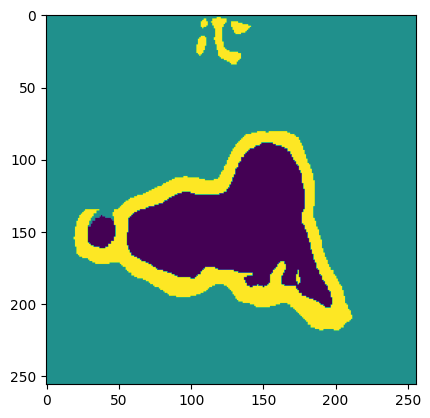

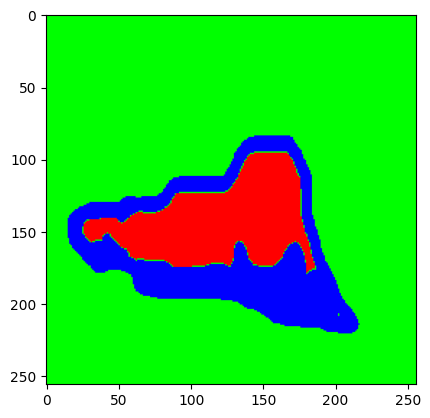

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019843975..1.0000002].


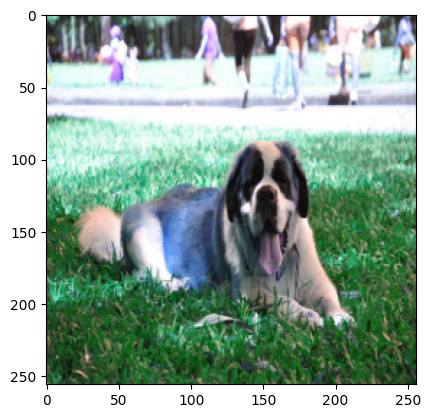

In [54]:
sample_index =  torch.randint(0, len(test_dataloader), size= (1,))
sample_input, sample_target = next(itertools.islice(test_dataloader,
                                                    sample_index, None))

sample_output = model(sample_input.cuda())

sample_output = torch.argmax(N.Softmax(dim= 1)(sample_output), dim= 1)

idx = torch.randint(0, batch_size, size= (1,))

plt.imshow(sample_output[idx].squeeze().cpu())
plt.show()
plt.imshow(sample_target[idx].squeeze().permute(1,2,0))
plt.show()
plt.imshow(sample_input[idx].squeeze().permute(1,2,0))

In [ ]:
torch.save(model, '../pytorch-basics/models/img-seg-transunet.pt')

In [56]:
keys = epoch_snapshot[0].keys()

with open('../pytorch-basics/training-history-transunet.csv', 'w') as f:
    writer = csv.DictWriter(f, fieldnames= keys)
    writer.writeheader()
    writer.writerows(epoch_snapshot)